# TD 04 GAN

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# torch stuff
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Génération des données

- un cercle de rayon 3 centré en (0,0)
- une sinusoide d'amplitude 1 et de fréquence 6 $\pi$
- une bande délimitée par deux  sinusoïdes (répartition graduelle en tanh)


Les données seront légerement perturbées par un bruit gaussien d'amplitude 0.1

In [2]:
# return N data drawn according to the wanted density
def f_data(N, model='circle'):
  eps = np.random.randn(N) # Gaussian noise

  if model == 'circle':
    t = np.random.rand(N)# Uniform
    # Circle of radius 3 and centered in 0: x = R*cos(2pit), y = Rsin(2pit)
    x = 3*np.cos(2*np.pi*t) + eps
    y = 3*np.sin(2*np.pi*t) + eps # Using the same noise (we could also use another one for y)
    return np.column_stack((x,y))

  z1 = 3*np.random.randn(N) # Gaussian
  if model == 'simple_sin':
    # Sinusoid of amplitude 1 and frequency 6pi
    y = np.sin(6*np.pi*z1) + eps
    return np.column_stack((z1,y))
  
  elif model == 'double_sin':
    z2 = 3*np.random.randn(N) # Gaussian (2)
    return np.column_stack((z1+0.1*eps,np.cos(z1)+np.tanh(z2)+0.1*eps))

## Design des réseaux

Générateur, il doit être en mesure de produire des données pour notre problème.

Première couche est l'espace du latent `sz_latent`, une couche cachée de taille `sz_hidden` et une couche de sortie

In [3]:
class Generator(nn.Module):
  def __init__(self, sz_latent,sz_hidden):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(sz_latent,sz_hidden)
    self.fc2 = nn.Linear(sz_hidden,sz_hidden)
    self.fout = nn.Linear(sz_hidden,2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fout(x)
    return x

Le réseau critique, est un MLP qui doit déterminer si les données sont réelles ou fausses.

Il comporte trois couches, la première étant de taille `sz`. La taille des deux couches suivantes est deux fois moindre que sa précédente. La décision finale est la probabilité que la donnée d’entrée soit réelle (ou fake).

In [4]:
class Discriminator(nn.Module):
  def __init__(self, sz):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(2,sz)
    self.fc2 = nn.Linear(sz,int(sz/2))
    self.fc3 = nn.Linear(int(sz/2),int(sz/4))
    self.fout = nn.Linear(int(sz/4),1) # un seul neurone pour la proba [0,1]
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fout(x)) # decision (proba)
    return x

## Apprentissage

In [5]:
def extract(v):
    return v.data.storage().tolist()

def train(batch_size, model, device, G, D, criterion, d_optimizer, g_optimizer, latent_dim, epochs):
  for epoch in range(epochs):
      for ii in range(20):  # train D for 20 steps
        D.zero_grad() # could be d_optimizer.zero_grad() since the optimizer is specific to the model

        # train D on real data
        d_real_data = (torch.FloatTensor(f_data(batch_size,model))).to(device)
        d_real_decision = D(d_real_data)
        d_real_error = criterion(d_real_decision, torch.ones([batch_size,1]).to(device))
        d_real_error.backward() # compute/store gradients, but don't change params

        # train D on fake data
        d_gen_seed = (torch.FloatTensor( torch.randn(batch_size,latent_dim ) )).to(device)  # TODO rand ou randn ?
        d_fake_data = G( d_gen_seed ).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(d_fake_data)
        d_fake_error = criterion(d_fake_decision, torch.zeros([batch_size,1]).to(device))
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

        dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

      for ii in range(20):  # train G for 20 steps
        G.zero_grad()

        g_gen_seed = (torch.FloatTensor( torch.randn(batch_size,latent_dim ))).to(device)
        g_fake_data = G( g_gen_seed )
        dg_fake_decision = D(g_fake_data)
        g_error = criterion(dg_fake_decision, torch.ones([batch_size,1]).to(device))  # Train G to pretend it's genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

        ge = extract(g_error)[0]
      if epoch % 20 ==0:
        print("Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) " % (epoch, dre, dfe, ge))

      if epoch % 60 == 0:
        g_gen_seed = (torch.FloatTensor( torch.randn(1000,latent_dim ))).to(device)
        g_fake_data = G( g_gen_seed ).detach().to("cpu")
        

        # plot ground truth
        if model == "circle":
          t=np.arange(0,1.1,0.025)
          plt.plot(3*np.cos(t*2*np.pi),3*np.sin(t*2*np.pi), 'r-')
        if model == "simple_sin":
          xx = np.arange(-3,3,0.25)
          plt.plot(3*xx,np.cos(3*xx), 'r-')
        if model == "double_sin":
          xx = np.arange(-3,3,0.25)
          plt.plot(3*xx,np.cos(3*xx)+1, 'r-')
          plt.plot(3*xx,np.cos(3*xx)-1, 'r-')

        plt.plot(g_fake_data[:,0],g_fake_data[:,1],'b.')
        plt.show()
        plt.close()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_params_training(latent_dim = 2):
    G = Generator(latent_dim,32).to(device)
    D = Discriminator(32).to(device)
    criterion = nn.BCELoss()
    d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.8)
    g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.8)
    # Adam optimizer
    #d_optimizer = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
    #g_optimizer = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return G, D, criterion, d_optimizer, g_optimizer

In [7]:
model = "circle"
# model = "simple_sin"
# model = "double_sin"
latent_dim = 2
# epochs = 3000
epochs = 2000
batch_size = 32
G, D, criterion, d_optimizer, g_optimizer = get_params_training(latent_dim)

C:\Users\clemm\AppData\Local\Temp\ipykernel_42272\3543923149.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return v.data.storage().tolist()


Epoch 0: D (0.7978 real_err, 0.6148 fake_err) G (0.7780 err) 


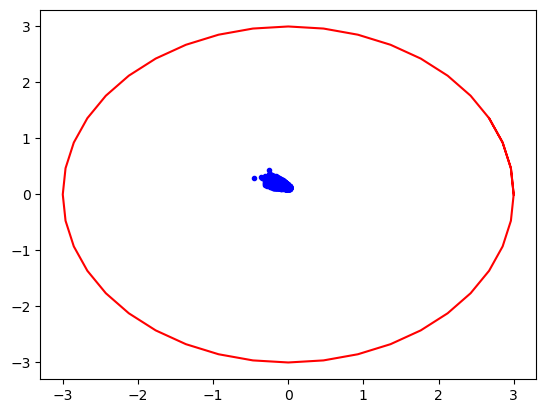

Epoch 20: D (0.6162 real_err, 0.6045 fake_err) G (0.7913 err) 
Epoch 40: D (0.1929 real_err, 0.3610 fake_err) G (1.1834 err) 
Epoch 60: D (0.6603 real_err, 0.2478 fake_err) G (1.4296 err) 


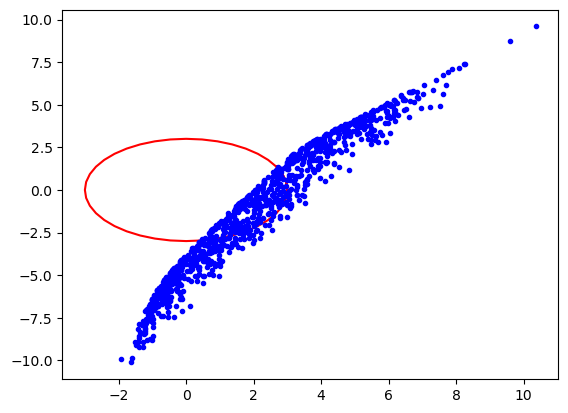

Epoch 80: D (0.4655 real_err, 0.4098 fake_err) G (1.0756 err) 
Epoch 100: D (0.5144 real_err, 0.4219 fake_err) G (1.1065 err) 
Epoch 120: D (0.7010 real_err, 0.4862 fake_err) G (0.9648 err) 


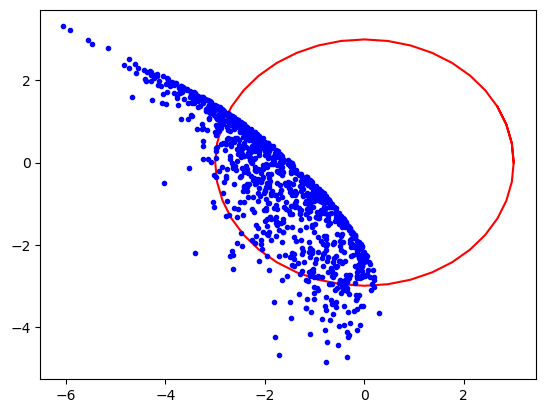

Epoch 140: D (0.7454 real_err, 0.6223 fake_err) G (0.8447 err) 
Epoch 160: D (0.7210 real_err, 0.6399 fake_err) G (0.7903 err) 
Epoch 180: D (0.6924 real_err, 0.6976 fake_err) G (0.7690 err) 


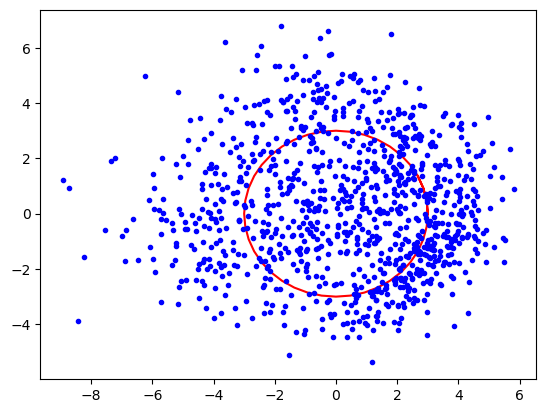

Epoch 200: D (0.6441 real_err, 0.7368 fake_err) G (0.6621 err) 
Epoch 220: D (0.6871 real_err, 0.6810 fake_err) G (0.7171 err) 
Epoch 240: D (0.6897 real_err, 0.6797 fake_err) G (0.7008 err) 


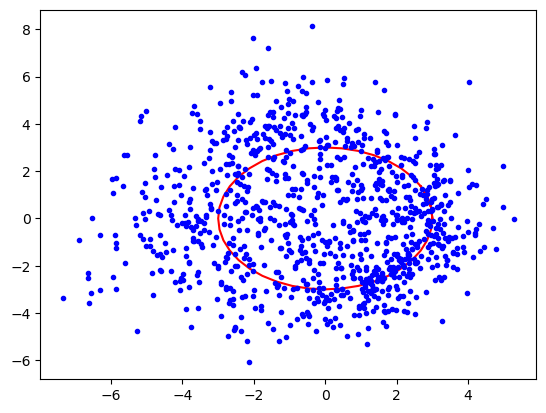

Epoch 260: D (0.6977 real_err, 0.6891 fake_err) G (0.7132 err) 
Epoch 280: D (0.6975 real_err, 0.6826 fake_err) G (0.7130 err) 
Epoch 300: D (0.6825 real_err, 0.6816 fake_err) G (0.7037 err) 


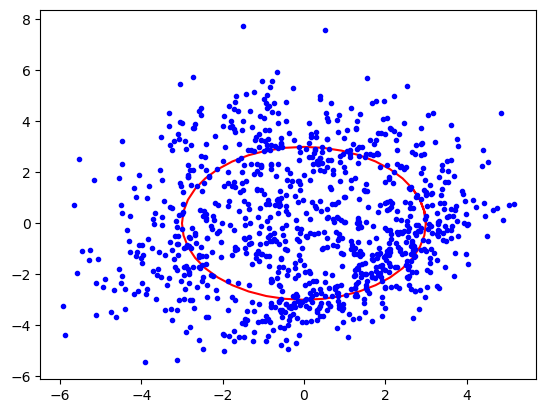

Epoch 320: D (0.6802 real_err, 0.6668 fake_err) G (0.7074 err) 
Epoch 340: D (0.6843 real_err, 0.6734 fake_err) G (0.7049 err) 
Epoch 360: D (0.7086 real_err, 0.6636 fake_err) G (0.7079 err) 


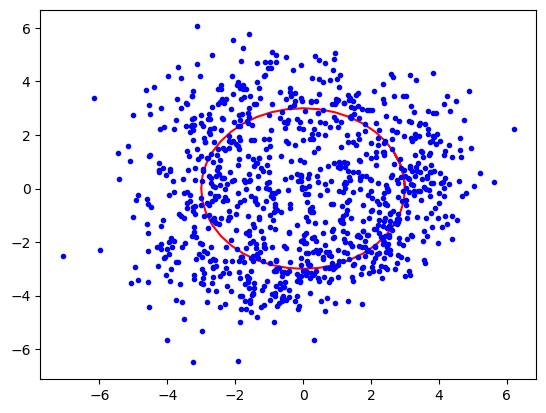

Epoch 380: D (0.6812 real_err, 0.6718 fake_err) G (0.6973 err) 
Epoch 400: D (0.6801 real_err, 0.6820 fake_err) G (0.7133 err) 
Epoch 420: D (0.6974 real_err, 0.6770 fake_err) G (0.7108 err) 


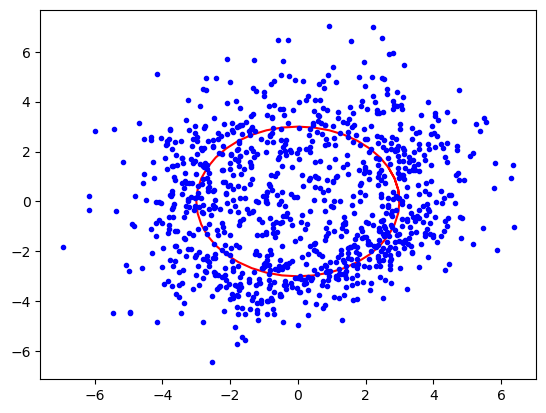

Epoch 440: D (0.6962 real_err, 0.6955 fake_err) G (0.7051 err) 
Epoch 460: D (0.6990 real_err, 0.6617 fake_err) G (0.7215 err) 
Epoch 480: D (0.7113 real_err, 0.6564 fake_err) G (0.7260 err) 


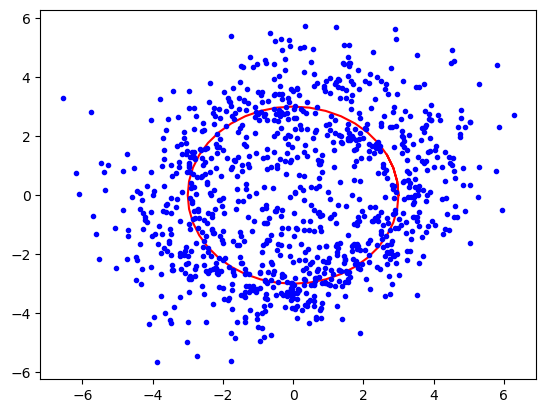

Epoch 500: D (0.6930 real_err, 0.6640 fake_err) G (0.6940 err) 
Epoch 520: D (0.6972 real_err, 0.6837 fake_err) G (0.7081 err) 
Epoch 540: D (0.6747 real_err, 0.6763 fake_err) G (0.7110 err) 


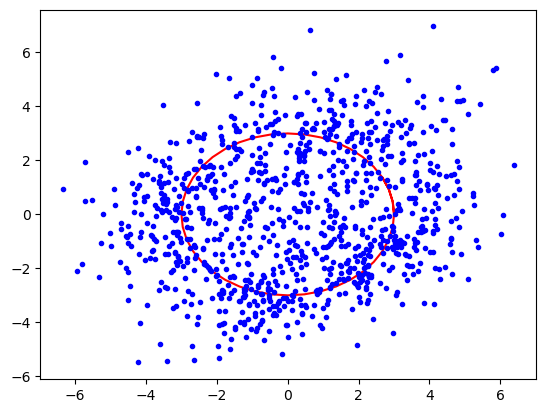

Epoch 560: D (0.7017 real_err, 0.6739 fake_err) G (0.7130 err) 
Epoch 580: D (0.7141 real_err, 0.6653 fake_err) G (0.7227 err) 
Epoch 600: D (0.6887 real_err, 0.6818 fake_err) G (0.7200 err) 


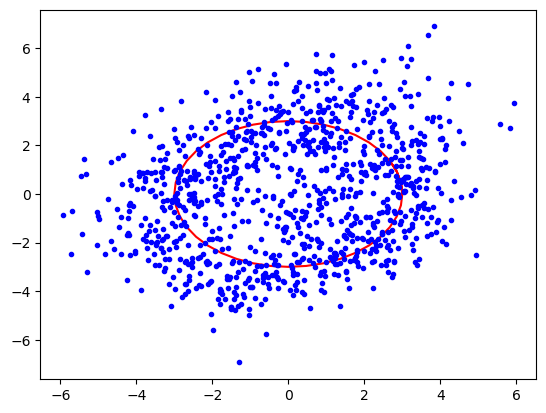

Epoch 620: D (0.6883 real_err, 0.6682 fake_err) G (0.6957 err) 
Epoch 640: D (0.6904 real_err, 0.6775 fake_err) G (0.7139 err) 
Epoch 660: D (0.7118 real_err, 0.6586 fake_err) G (0.7261 err) 


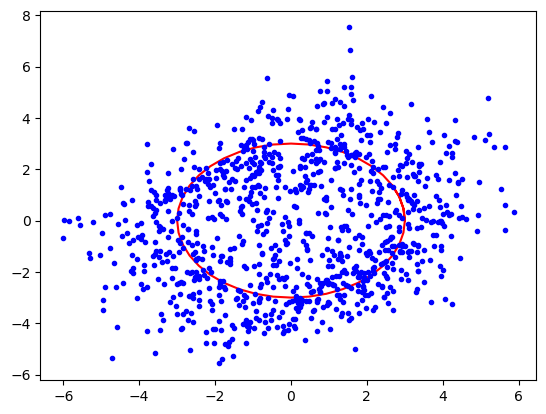

Epoch 680: D (0.6959 real_err, 0.6779 fake_err) G (0.7080 err) 
Epoch 700: D (0.7215 real_err, 0.6860 fake_err) G (0.7136 err) 
Epoch 720: D (0.7002 real_err, 0.6870 fake_err) G (0.7094 err) 


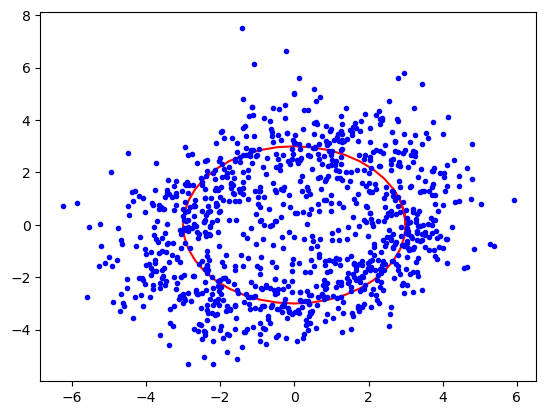

Epoch 740: D (0.6820 real_err, 0.6731 fake_err) G (0.6850 err) 
Epoch 760: D (0.6852 real_err, 0.6902 fake_err) G (0.7649 err) 
Epoch 780: D (0.7021 real_err, 0.6792 fake_err) G (0.7242 err) 


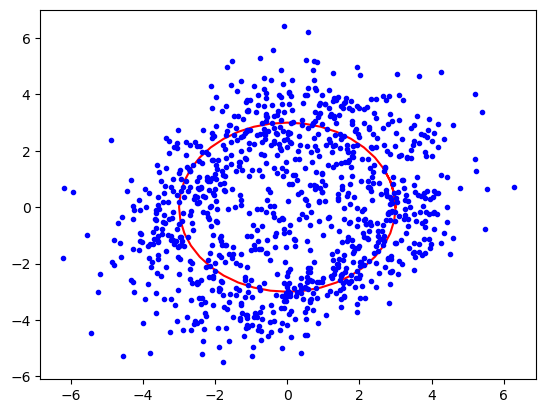

Epoch 800: D (0.6942 real_err, 0.6687 fake_err) G (0.7155 err) 
Epoch 820: D (0.6904 real_err, 0.6851 fake_err) G (0.7070 err) 
Epoch 840: D (0.6871 real_err, 0.6597 fake_err) G (0.7099 err) 


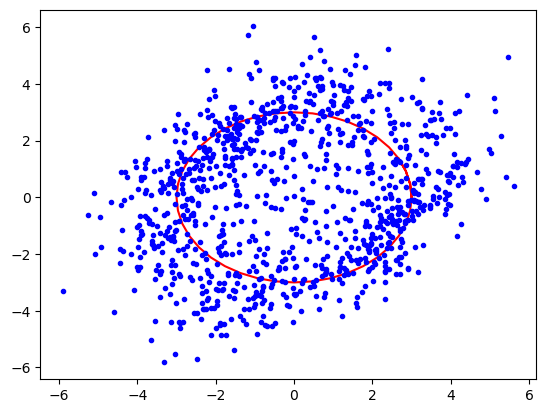

Epoch 860: D (0.7178 real_err, 0.6657 fake_err) G (0.7188 err) 
Epoch 880: D (0.6969 real_err, 0.6827 fake_err) G (0.7416 err) 
Epoch 900: D (0.6851 real_err, 0.6791 fake_err) G (0.7391 err) 


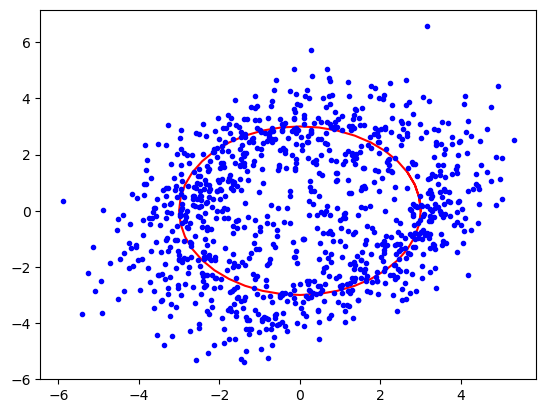

Epoch 920: D (0.7158 real_err, 0.6886 fake_err) G (0.7109 err) 
Epoch 940: D (0.7028 real_err, 0.6836 fake_err) G (0.7278 err) 
Epoch 960: D (0.6680 real_err, 0.6639 fake_err) G (0.7183 err) 


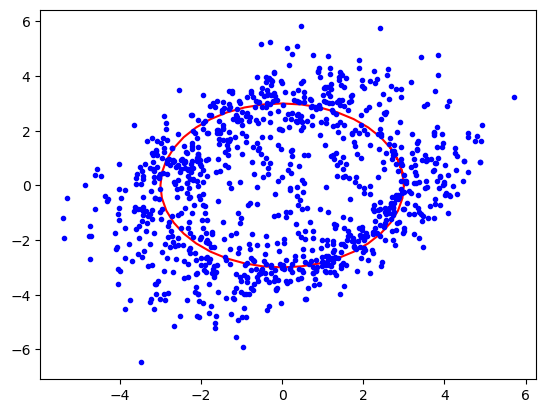

Epoch 980: D (0.6680 real_err, 0.6829 fake_err) G (0.6880 err) 
Epoch 1000: D (0.6940 real_err, 0.6888 fake_err) G (0.7180 err) 
Epoch 1020: D (0.7169 real_err, 0.6867 fake_err) G (0.7113 err) 


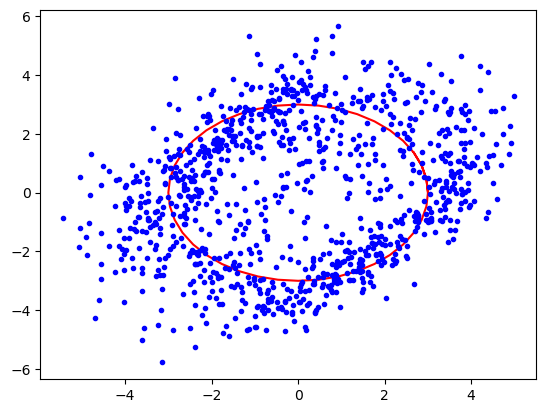

Epoch 1040: D (0.7032 real_err, 0.6734 fake_err) G (0.6958 err) 
Epoch 1060: D (0.6890 real_err, 0.6856 fake_err) G (0.6875 err) 
Epoch 1080: D (0.7100 real_err, 0.6588 fake_err) G (0.7236 err) 


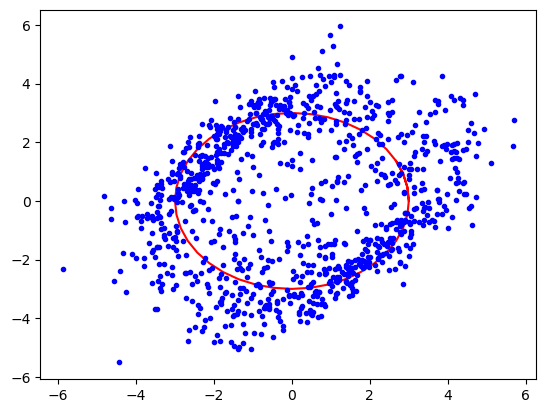

Epoch 1100: D (0.6938 real_err, 0.6557 fake_err) G (0.7181 err) 
Epoch 1120: D (0.6833 real_err, 0.6908 fake_err) G (0.6865 err) 
Epoch 1140: D (0.6822 real_err, 0.6803 fake_err) G (0.6957 err) 


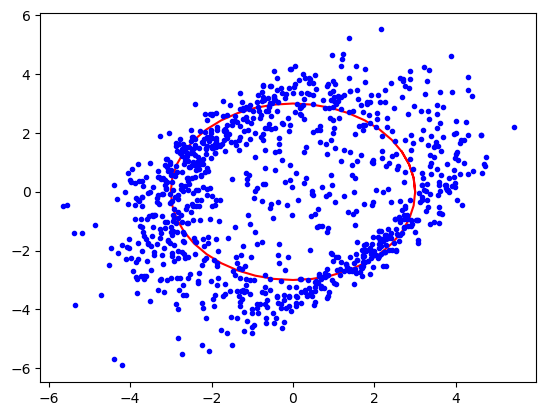

Epoch 1160: D (0.7148 real_err, 0.7018 fake_err) G (0.7028 err) 
Epoch 1180: D (0.6930 real_err, 0.6896 fake_err) G (0.6940 err) 
Epoch 1200: D (0.6989 real_err, 0.6932 fake_err) G (0.6843 err) 


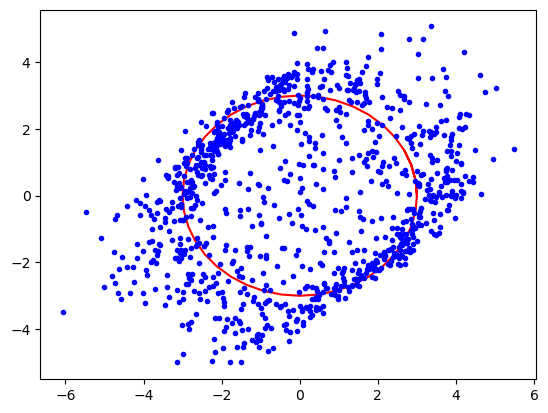

Epoch 1220: D (0.6899 real_err, 0.6840 fake_err) G (0.7163 err) 
Epoch 1240: D (0.7051 real_err, 0.6767 fake_err) G (0.7063 err) 
Epoch 1260: D (0.6957 real_err, 0.6925 fake_err) G (0.6855 err) 


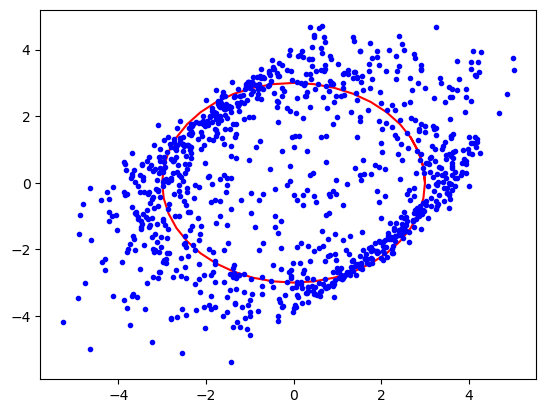

Epoch 1280: D (0.7073 real_err, 0.6690 fake_err) G (0.7095 err) 
Epoch 1300: D (0.6846 real_err, 0.6963 fake_err) G (0.7114 err) 
Epoch 1320: D (0.6871 real_err, 0.6732 fake_err) G (0.6921 err) 


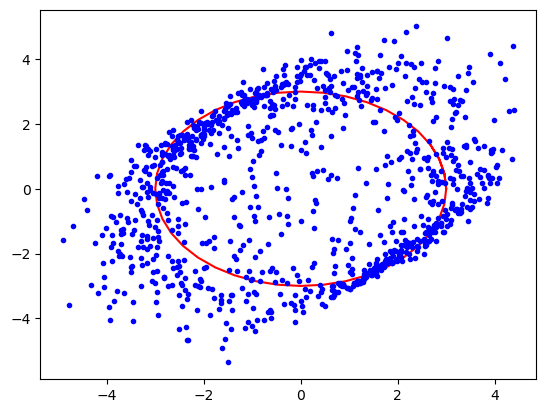

Epoch 1340: D (0.6918 real_err, 0.6831 fake_err) G (0.7055 err) 
Epoch 1360: D (0.6891 real_err, 0.6840 fake_err) G (0.6956 err) 
Epoch 1380: D (0.6928 real_err, 0.6919 fake_err) G (0.6995 err) 


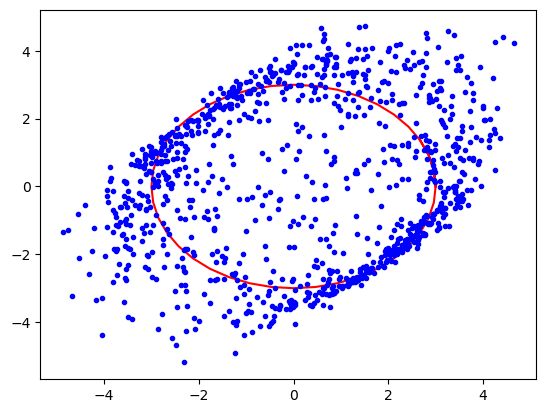

Epoch 1400: D (0.6930 real_err, 0.6808 fake_err) G (0.7094 err) 
Epoch 1420: D (0.6934 real_err, 0.6992 fake_err) G (0.6904 err) 
Epoch 1440: D (0.6979 real_err, 0.6946 fake_err) G (0.6992 err) 


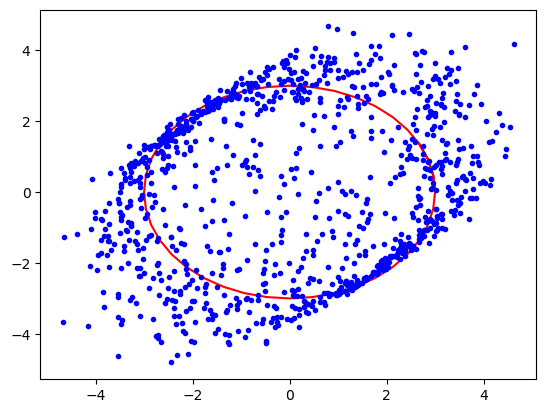

Epoch 1460: D (0.7140 real_err, 0.6782 fake_err) G (0.7020 err) 
Epoch 1480: D (0.6791 real_err, 0.7073 fake_err) G (0.6843 err) 
Epoch 1500: D (0.7000 real_err, 0.6910 fake_err) G (0.7020 err) 


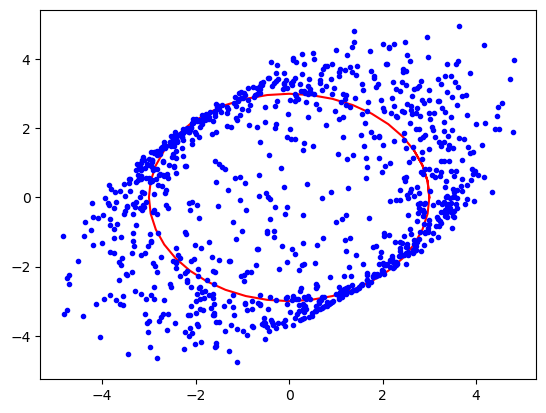

Epoch 1520: D (0.6722 real_err, 0.7133 fake_err) G (0.6778 err) 
Epoch 1540: D (0.6935 real_err, 0.7026 fake_err) G (0.6972 err) 
Epoch 1560: D (0.6824 real_err, 0.7087 fake_err) G (0.6794 err) 


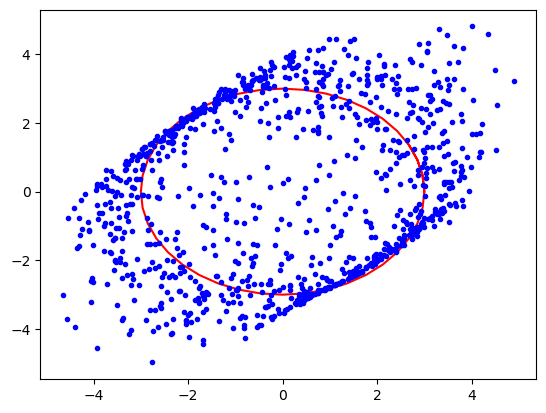

Epoch 1580: D (0.6872 real_err, 0.6893 fake_err) G (0.6959 err) 
Epoch 1600: D (0.6900 real_err, 0.7005 fake_err) G (0.7059 err) 
Epoch 1620: D (0.6913 real_err, 0.6928 fake_err) G (0.7073 err) 


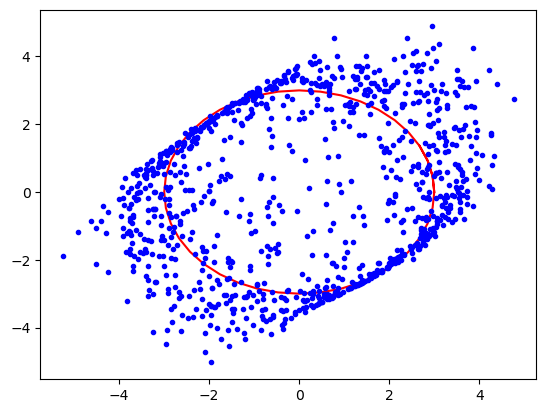

Epoch 1640: D (0.6868 real_err, 0.7002 fake_err) G (0.6809 err) 
Epoch 1660: D (0.6951 real_err, 0.6915 fake_err) G (0.7004 err) 
Epoch 1680: D (0.6815 real_err, 0.6995 fake_err) G (0.6888 err) 


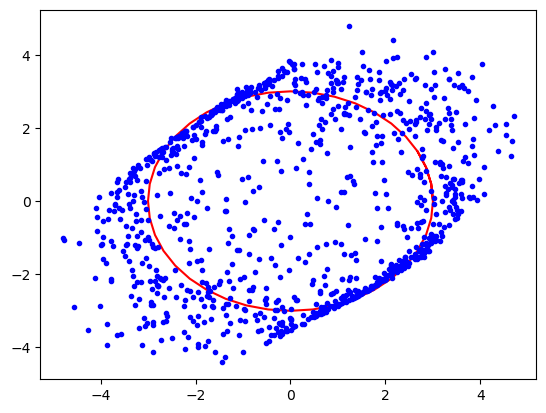

Epoch 1700: D (0.6936 real_err, 0.6888 fake_err) G (0.6848 err) 
Epoch 1720: D (0.6891 real_err, 0.7002 fake_err) G (0.6850 err) 
Epoch 1740: D (0.6906 real_err, 0.6965 fake_err) G (0.6799 err) 


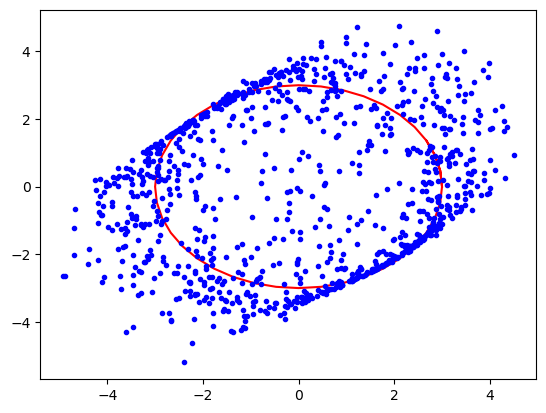

Epoch 1760: D (0.6800 real_err, 0.6961 fake_err) G (0.6861 err) 
Epoch 1780: D (0.6910 real_err, 0.6953 fake_err) G (0.6918 err) 
Epoch 1800: D (0.6870 real_err, 0.7037 fake_err) G (0.6826 err) 


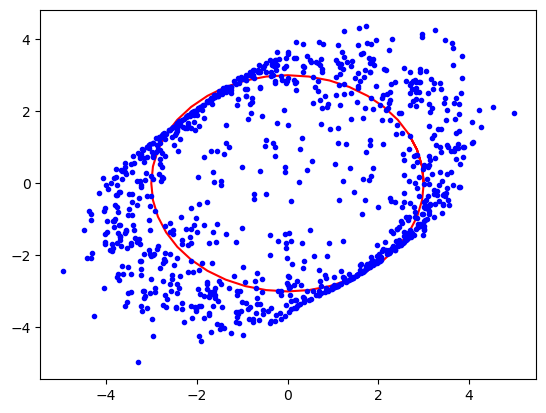

Epoch 1820: D (0.7047 real_err, 0.6879 fake_err) G (0.7074 err) 
Epoch 1840: D (0.6935 real_err, 0.6944 fake_err) G (0.6960 err) 
Epoch 1860: D (0.6979 real_err, 0.6907 fake_err) G (0.6980 err) 


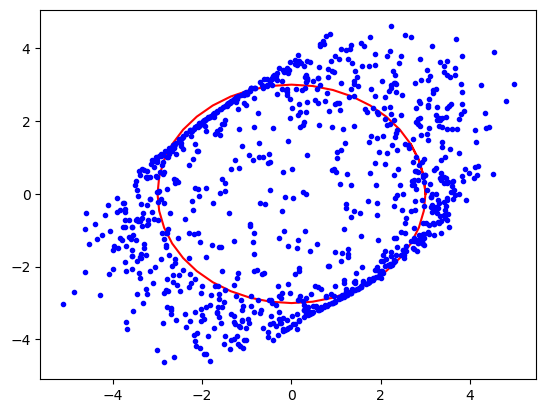

Epoch 1880: D (0.6889 real_err, 0.6979 fake_err) G (0.6901 err) 
Epoch 1900: D (0.6906 real_err, 0.6936 fake_err) G (0.6928 err) 
Epoch 1920: D (0.6920 real_err, 0.6960 fake_err) G (0.6882 err) 


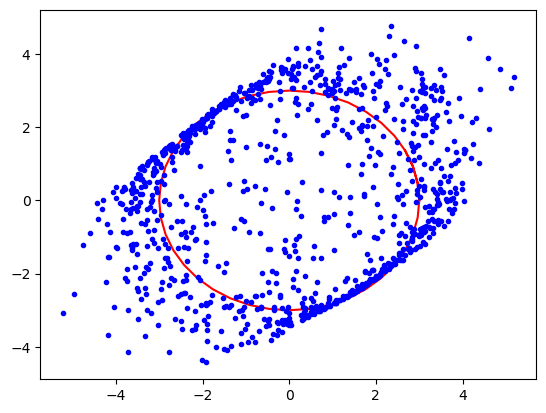

Epoch 1940: D (0.6970 real_err, 0.6976 fake_err) G (0.6829 err) 
Epoch 1960: D (0.7023 real_err, 0.6865 fake_err) G (0.6989 err) 
Epoch 1980: D (0.6948 real_err, 0.6896 fake_err) G (0.6965 err) 


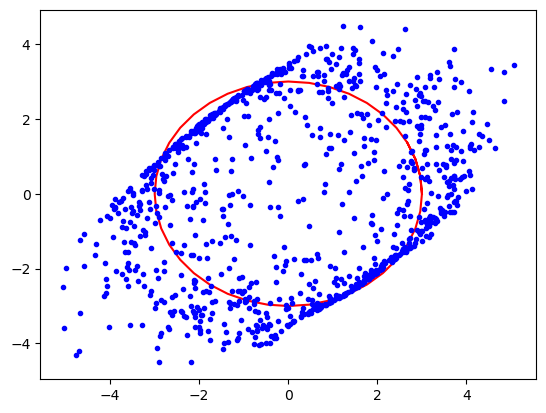

In [8]:
train(batch_size, model, device, G, D, criterion, d_optimizer, g_optimizer, latent_dim, epochs)

**Que se passe t'il si l'on réduit la dimension de l'espace latent ?**

In [9]:
# model = "circle"
# model = "simple_sin"
model = "double_sin"
latent_dim = 1
epochs = 3000
# epochs = 2000
G, D, criterion, d_optimizer, g_optimizer = get_params_training(latent_dim)

Epoch 0: D (0.6585 real_err, 0.7487 fake_err) G (0.6404 err) 


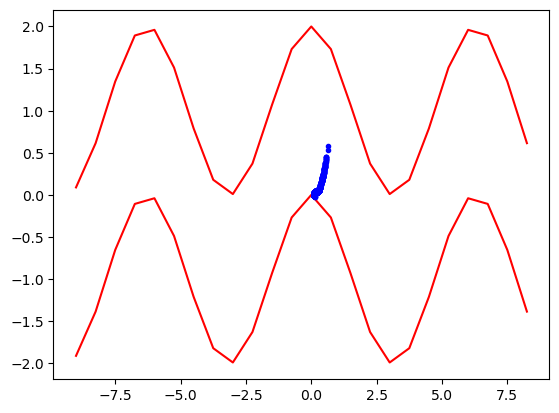

Epoch 20: D (0.6284 real_err, 0.7204 fake_err) G (0.6672 err) 
Epoch 40: D (0.5477 real_err, 0.6956 fake_err) G (0.6755 err) 
Epoch 60: D (0.3881 real_err, 0.5360 fake_err) G (0.8699 err) 


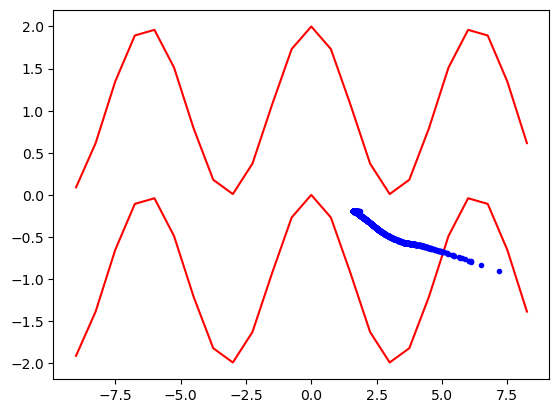

Epoch 80: D (0.4494 real_err, 0.5693 fake_err) G (0.8382 err) 
Epoch 100: D (0.6519 real_err, 0.4518 fake_err) G (1.0231 err) 
Epoch 120: D (0.6276 real_err, 0.4476 fake_err) G (0.9008 err) 


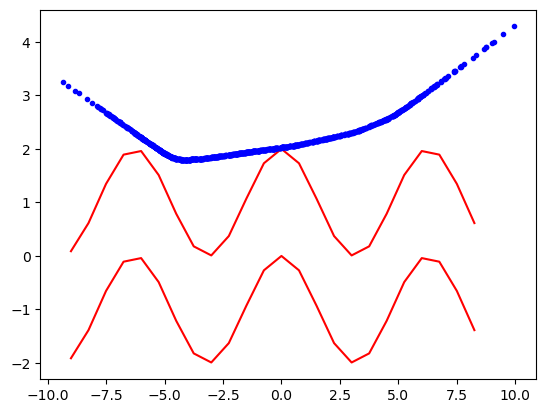

Epoch 140: D (0.8643 real_err, 0.4545 fake_err) G (0.9771 err) 
Epoch 160: D (0.4640 real_err, 0.4395 fake_err) G (0.2490 err) 
Epoch 180: D (0.6476 real_err, 0.5606 fake_err) G (0.8125 err) 


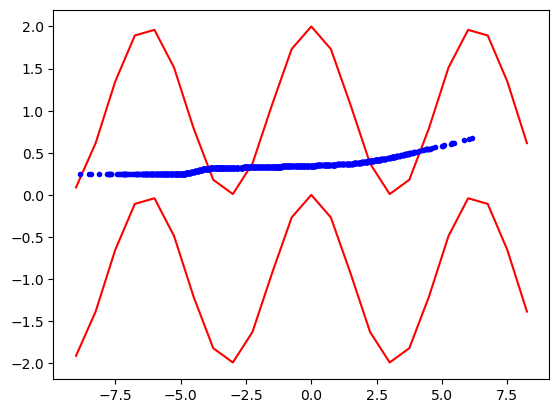

Epoch 200: D (1.0179 real_err, 0.3930 fake_err) G (1.0255 err) 
Epoch 220: D (0.3144 real_err, 0.5566 fake_err) G (0.8319 err) 
Epoch 240: D (0.6943 real_err, 0.5788 fake_err) G (0.8049 err) 


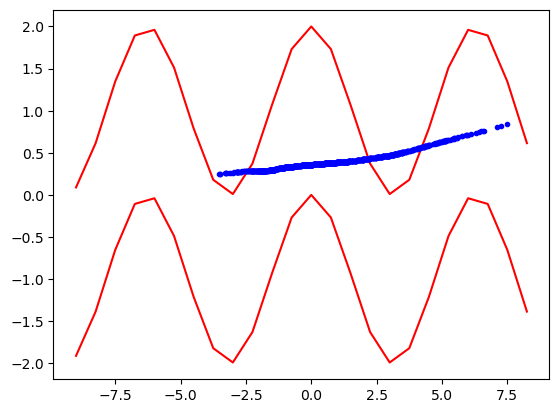

Epoch 260: D (0.5865 real_err, 0.5666 fake_err) G (0.8469 err) 
Epoch 280: D (0.4667 real_err, 0.4639 fake_err) G (0.9879 err) 
Epoch 300: D (0.9069 real_err, 0.5288 fake_err) G (0.7980 err) 


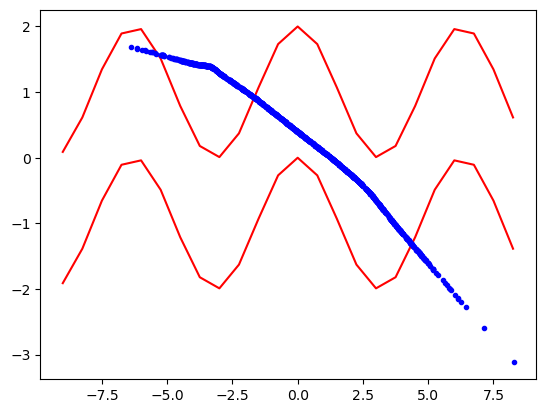

Epoch 320: D (0.7211 real_err, 0.6660 fake_err) G (0.7221 err) 
Epoch 340: D (0.6895 real_err, 0.6964 fake_err) G (0.6936 err) 
Epoch 360: D (0.7007 real_err, 0.6895 fake_err) G (0.6980 err) 


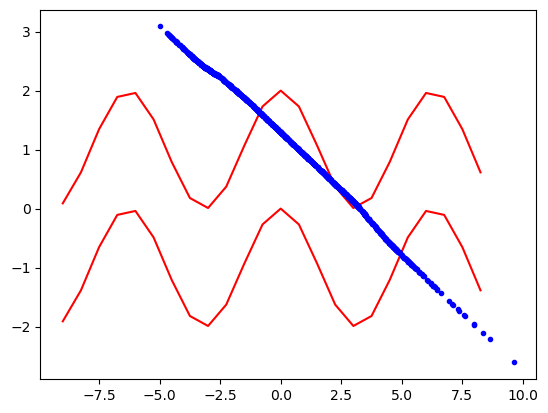

Epoch 380: D (0.7006 real_err, 0.6858 fake_err) G (0.7007 err) 
Epoch 400: D (0.6980 real_err, 0.6889 fake_err) G (0.6972 err) 
Epoch 420: D (0.6982 real_err, 0.6876 fake_err) G (0.6997 err) 


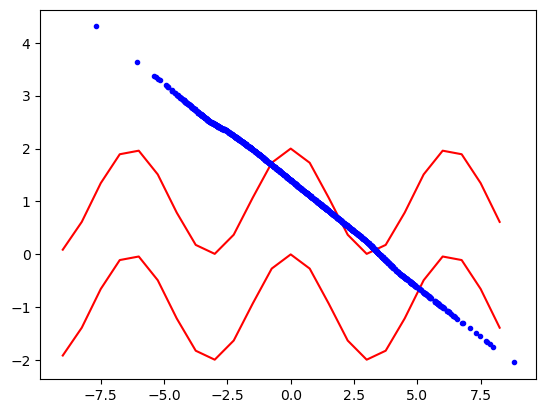

Epoch 440: D (0.6920 real_err, 0.6951 fake_err) G (0.6922 err) 
Epoch 460: D (0.6934 real_err, 0.6932 fake_err) G (0.6932 err) 
Epoch 480: D (0.6853 real_err, 0.6961 fake_err) G (0.6903 err) 


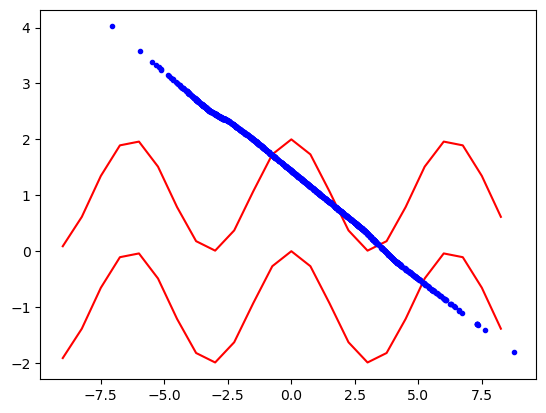

Epoch 500: D (0.6941 real_err, 0.6920 fake_err) G (0.6940 err) 
Epoch 520: D (0.7000 real_err, 0.6838 fake_err) G (0.7000 err) 
Epoch 540: D (0.6934 real_err, 0.6922 fake_err) G (0.6936 err) 


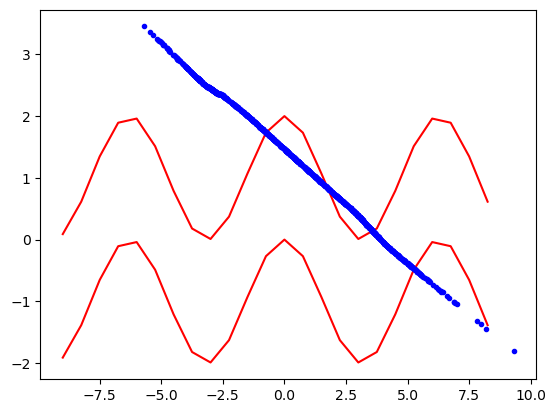

Epoch 560: D (0.6977 real_err, 0.6858 fake_err) G (0.6985 err) 
Epoch 580: D (0.7013 real_err, 0.6804 fake_err) G (0.7010 err) 
Epoch 600: D (0.6990 real_err, 0.6750 fake_err) G (0.7090 err) 


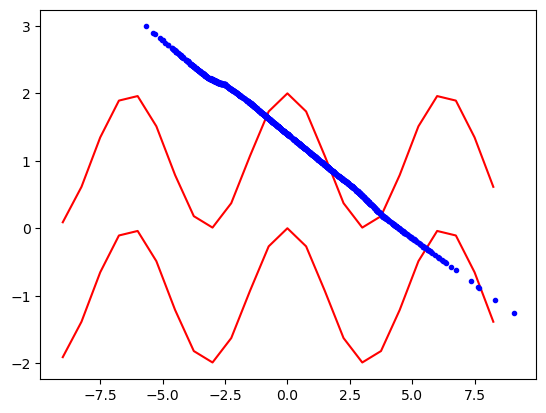

Epoch 620: D (0.7256 real_err, 0.6509 fake_err) G (0.7356 err) 
Epoch 640: D (0.7065 real_err, 0.6713 fake_err) G (0.7067 err) 
Epoch 660: D (0.6551 real_err, 0.7141 fake_err) G (0.6692 err) 


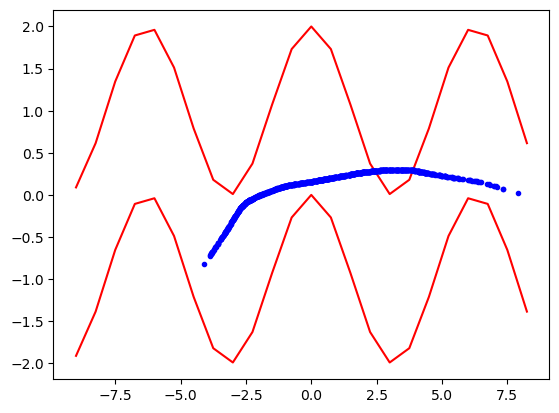

Epoch 680: D (0.6694 real_err, 0.7163 fake_err) G (0.6744 err) 
Epoch 700: D (0.6719 real_err, 0.7067 fake_err) G (0.6781 err) 
Epoch 720: D (0.6856 real_err, 0.7012 fake_err) G (0.6865 err) 


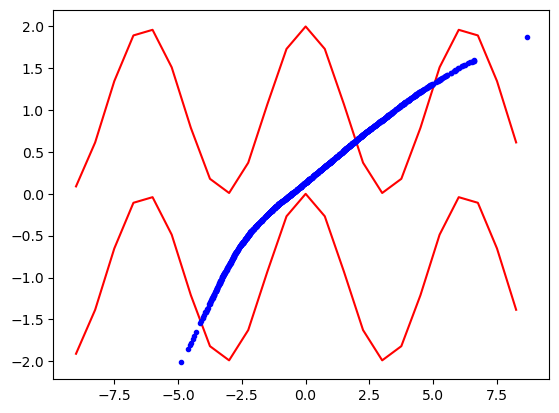

Epoch 740: D (0.6880 real_err, 0.6963 fake_err) G (0.6893 err) 
Epoch 760: D (0.6919 real_err, 0.6935 fake_err) G (0.6926 err) 
Epoch 780: D (0.6929 real_err, 0.6943 fake_err) G (0.6930 err) 


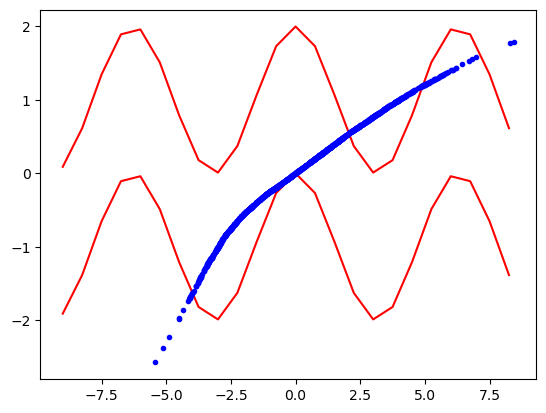

Epoch 800: D (0.6924 real_err, 0.6928 fake_err) G (0.6927 err) 
Epoch 820: D (0.6925 real_err, 0.6945 fake_err) G (0.6919 err) 
Epoch 840: D (0.6868 real_err, 0.6942 fake_err) G (0.6893 err) 


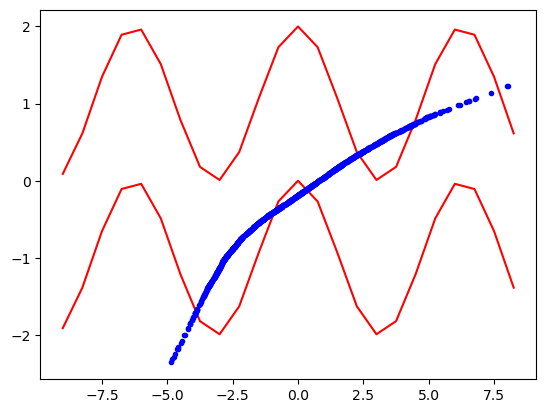

Epoch 860: D (0.6936 real_err, 0.6919 fake_err) G (0.6945 err) 
Epoch 880: D (0.6942 real_err, 0.6894 fake_err) G (0.6951 err) 
Epoch 900: D (0.6957 real_err, 0.6910 fake_err) G (0.6963 err) 


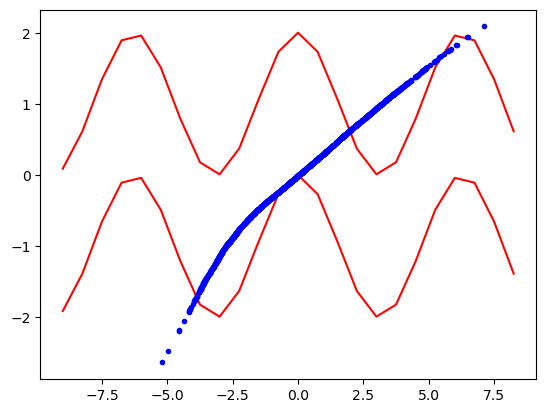

Epoch 920: D (0.6916 real_err, 0.6892 fake_err) G (0.7000 err) 
Epoch 940: D (0.6938 real_err, 0.6928 fake_err) G (0.6837 err) 
Epoch 960: D (0.6883 real_err, 0.6963 fake_err) G (0.6882 err) 


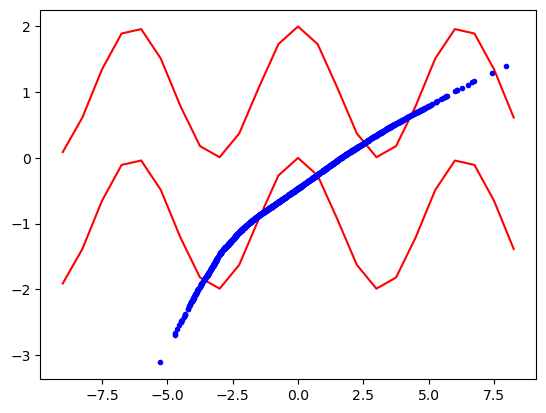

Epoch 980: D (0.7016 real_err, 0.6828 fake_err) G (0.6754 err) 
Epoch 1000: D (0.6845 real_err, 0.6941 fake_err) G (0.7065 err) 
Epoch 1020: D (0.6922 real_err, 0.6756 fake_err) G (0.6953 err) 


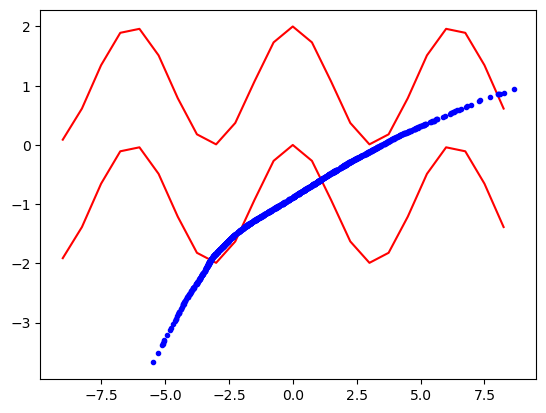

Epoch 1040: D (0.6932 real_err, 0.6810 fake_err) G (0.7020 err) 
Epoch 1060: D (0.7035 real_err, 0.6850 fake_err) G (0.7065 err) 
Epoch 1080: D (0.6941 real_err, 0.6918 fake_err) G (0.6929 err) 


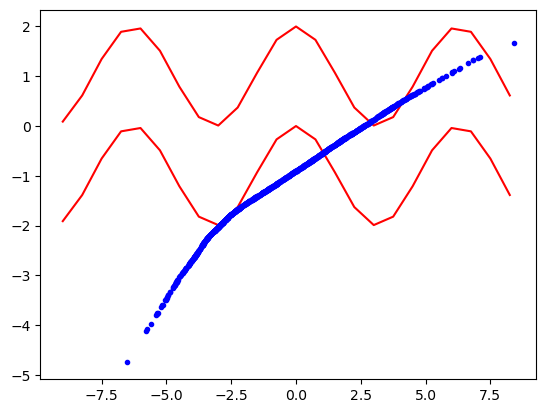

Epoch 1100: D (0.7019 real_err, 0.6886 fake_err) G (0.7030 err) 
Epoch 1120: D (0.6987 real_err, 0.6862 fake_err) G (0.6909 err) 
Epoch 1140: D (0.6968 real_err, 0.6883 fake_err) G (0.6860 err) 


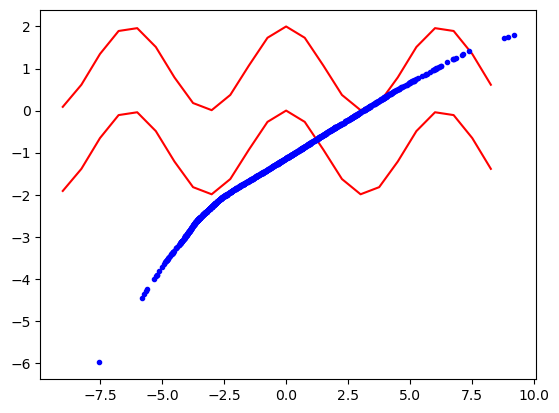

Epoch 1160: D (0.6942 real_err, 0.6763 fake_err) G (0.7064 err) 
Epoch 1180: D (0.6765 real_err, 0.6968 fake_err) G (0.6879 err) 
Epoch 1200: D (0.6142 real_err, 0.7004 fake_err) G (0.6873 err) 


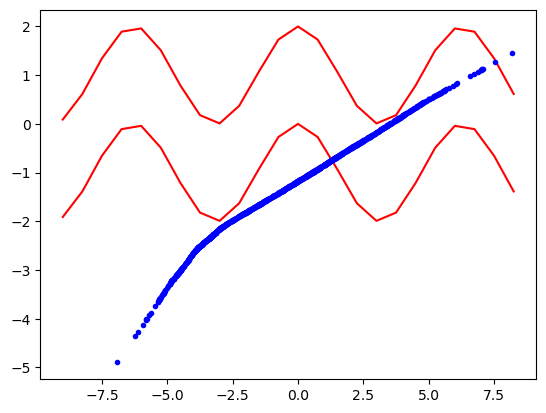

Epoch 1220: D (0.7451 real_err, 0.6579 fake_err) G (0.7291 err) 
Epoch 1240: D (0.6249 real_err, 0.6397 fake_err) G (0.7662 err) 
Epoch 1260: D (0.5788 real_err, 0.5913 fake_err) G (0.7898 err) 


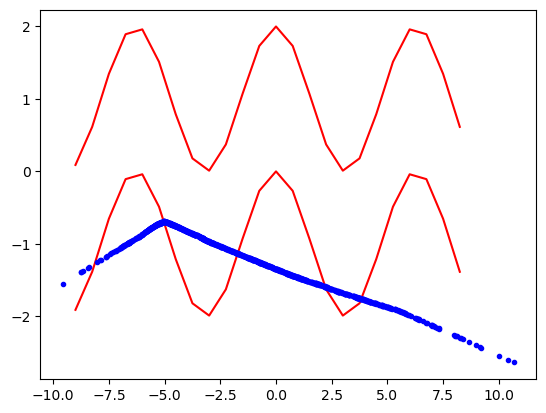

Epoch 1280: D (0.7579 real_err, 0.6347 fake_err) G (0.7481 err) 
Epoch 1300: D (0.6570 real_err, 0.6791 fake_err) G (0.7037 err) 
Epoch 1320: D (0.6647 real_err, 0.6095 fake_err) G (0.8185 err) 


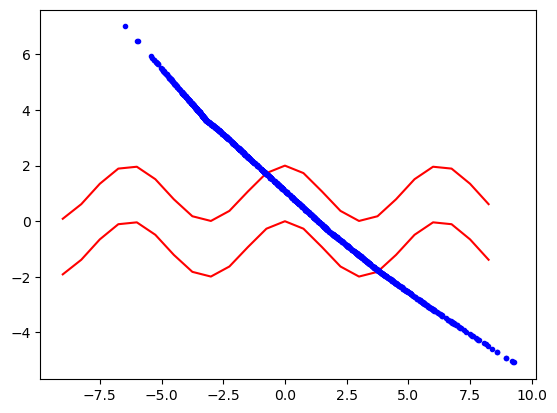

Epoch 1340: D (0.4943 real_err, 0.5990 fake_err) G (0.7992 err) 
Epoch 1360: D (0.4469 real_err, 0.5054 fake_err) G (0.6002 err) 
Epoch 1380: D (0.4847 real_err, 0.3039 fake_err) G (0.6847 err) 


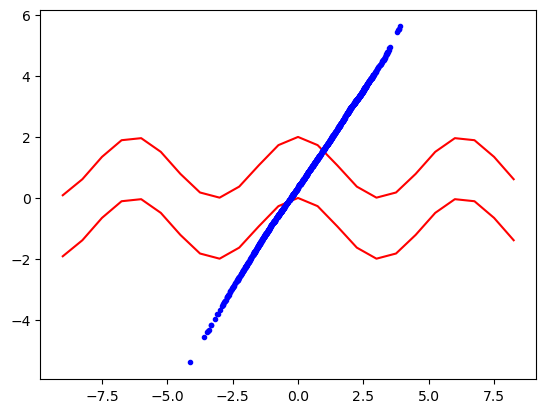

Epoch 1400: D (0.7126 real_err, 0.6364 fake_err) G (0.7479 err) 
Epoch 1420: D (0.6666 real_err, 0.5729 fake_err) G (0.6992 err) 
Epoch 1440: D (0.5494 real_err, 0.7308 fake_err) G (0.6599 err) 


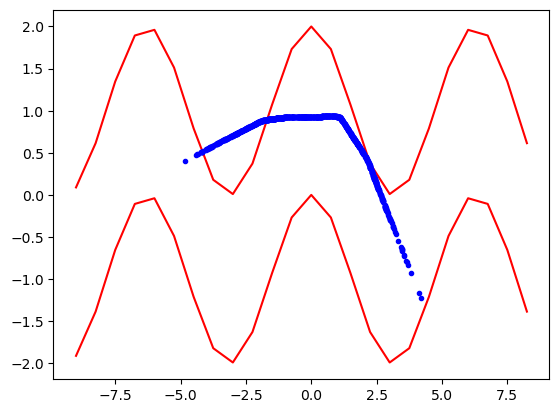

Epoch 1460: D (0.6529 real_err, 0.5488 fake_err) G (0.9048 err) 
Epoch 1480: D (0.8591 real_err, 0.6103 fake_err) G (0.7476 err) 
Epoch 1500: D (0.7963 real_err, 0.6233 fake_err) G (0.7673 err) 


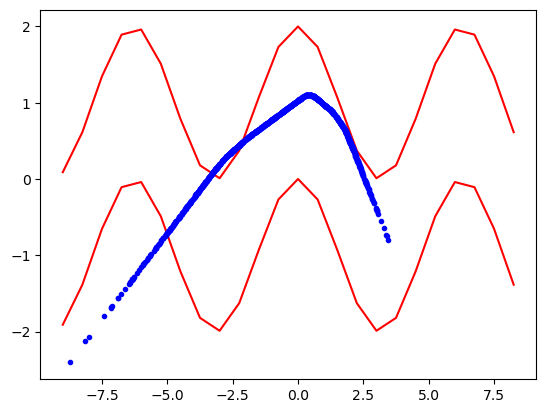

Epoch 1520: D (0.6609 real_err, 0.6219 fake_err) G (0.7201 err) 
Epoch 1540: D (0.6774 real_err, 0.6706 fake_err) G (0.7156 err) 
Epoch 1560: D (0.6266 real_err, 0.7565 fake_err) G (0.6228 err) 


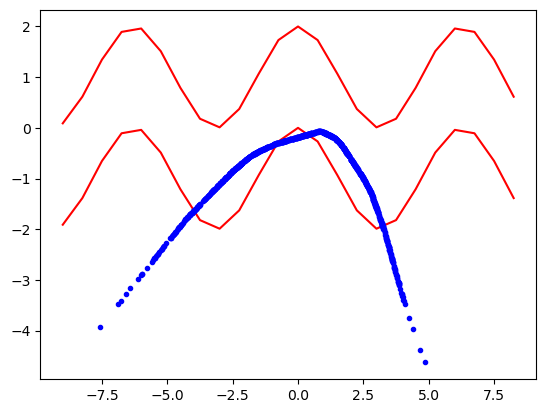

Epoch 1580: D (0.6635 real_err, 0.7197 fake_err) G (0.6096 err) 
Epoch 1600: D (0.7343 real_err, 0.6054 fake_err) G (0.7511 err) 
Epoch 1620: D (0.7460 real_err, 0.5778 fake_err) G (0.7700 err) 


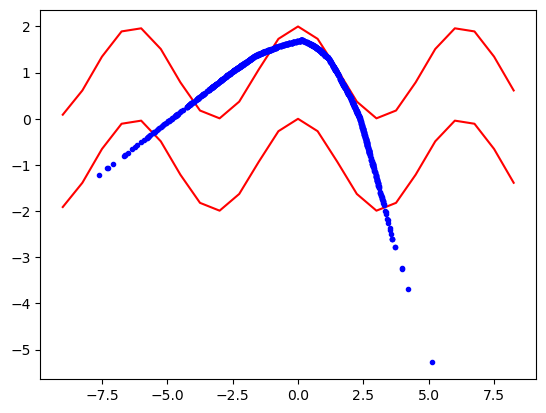

Epoch 1640: D (0.7837 real_err, 0.6019 fake_err) G (0.7952 err) 
Epoch 1660: D (0.7857 real_err, 0.5427 fake_err) G (0.7993 err) 
Epoch 1680: D (0.6849 real_err, 0.6098 fake_err) G (0.7645 err) 


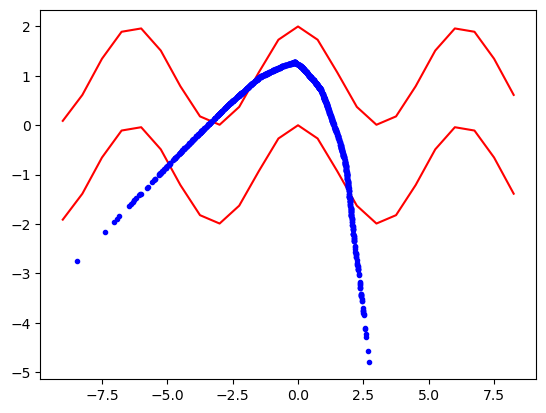

Epoch 1700: D (0.6938 real_err, 0.6487 fake_err) G (0.7205 err) 
Epoch 1720: D (0.6397 real_err, 0.6628 fake_err) G (0.7521 err) 
Epoch 1740: D (0.6592 real_err, 0.6626 fake_err) G (0.7283 err) 


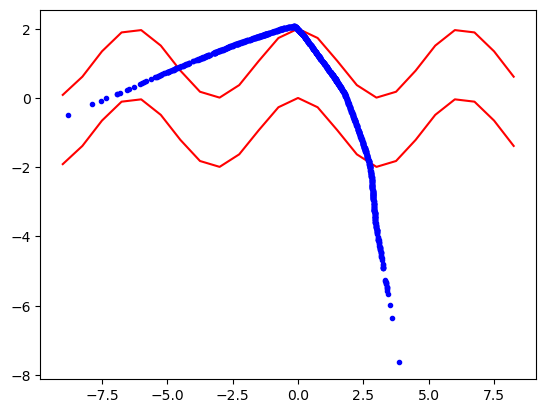

Epoch 1760: D (0.7369 real_err, 0.5645 fake_err) G (0.7249 err) 
Epoch 1780: D (0.7721 real_err, 0.5857 fake_err) G (0.8103 err) 
Epoch 1800: D (0.4352 real_err, 0.6385 fake_err) G (0.7285 err) 


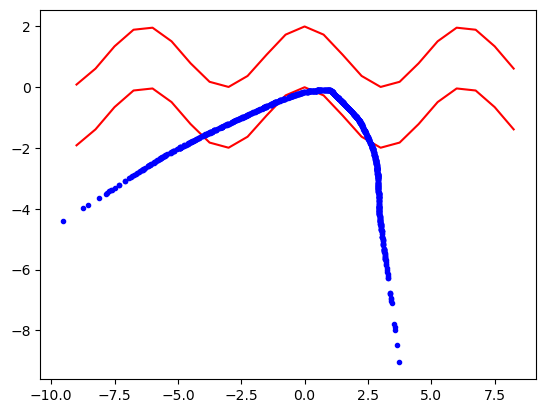

Epoch 1820: D (0.7782 real_err, 0.6259 fake_err) G (0.7723 err) 
Epoch 1840: D (0.7242 real_err, 0.6630 fake_err) G (0.7241 err) 
Epoch 1860: D (0.7043 real_err, 0.6821 fake_err) G (0.7043 err) 


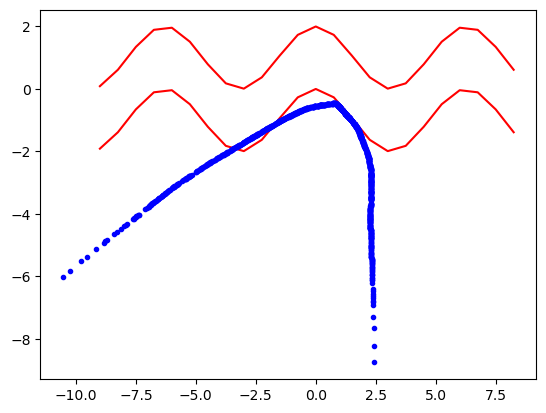

Epoch 1880: D (0.6972 real_err, 0.6891 fake_err) G (0.6972 err) 
Epoch 1900: D (0.6946 real_err, 0.6917 fake_err) G (0.6946 err) 
Epoch 1920: D (0.6937 real_err, 0.6926 fake_err) G (0.6937 err) 


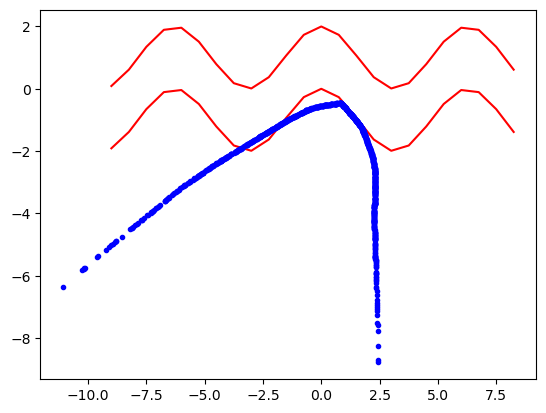

Epoch 1940: D (0.6933 real_err, 0.6930 fake_err) G (0.6933 err) 
Epoch 1960: D (0.6932 real_err, 0.6931 fake_err) G (0.6932 err) 
Epoch 1980: D (0.6932 real_err, 0.6931 fake_err) G (0.6932 err) 


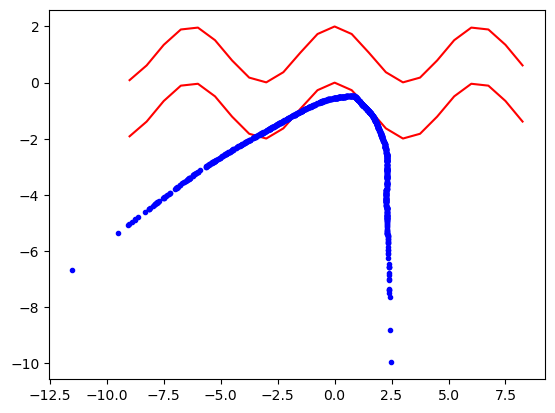

Epoch 2000: D (0.6932 real_err, 0.6931 fake_err) G (0.6932 err) 
Epoch 2020: D (0.6932 real_err, 0.6931 fake_err) G (0.6932 err) 
Epoch 2040: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


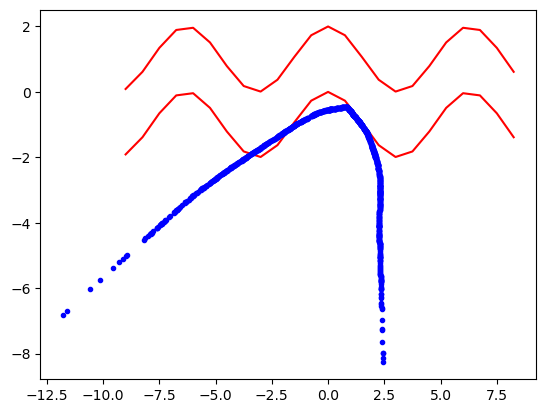

Epoch 2060: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2080: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2100: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


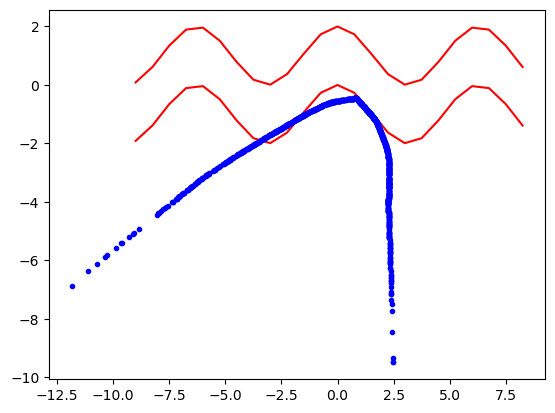

Epoch 2120: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2140: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2160: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


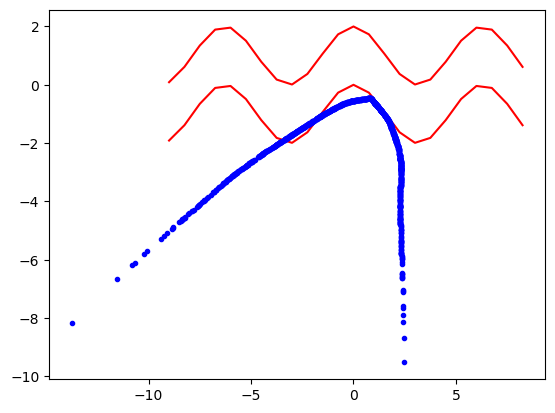

Epoch 2180: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2200: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2220: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


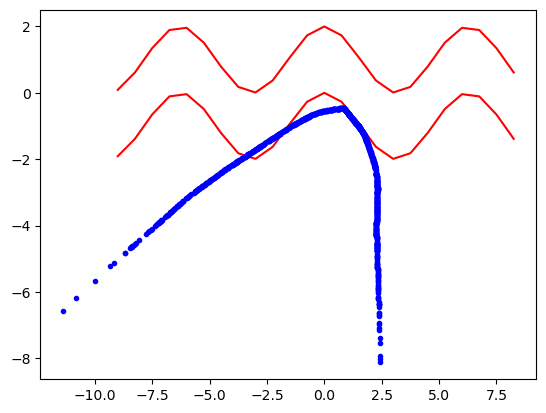

Epoch 2240: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2260: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2280: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


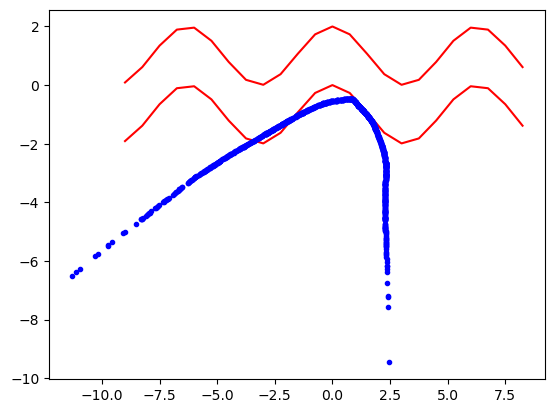

Epoch 2300: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2320: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2340: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


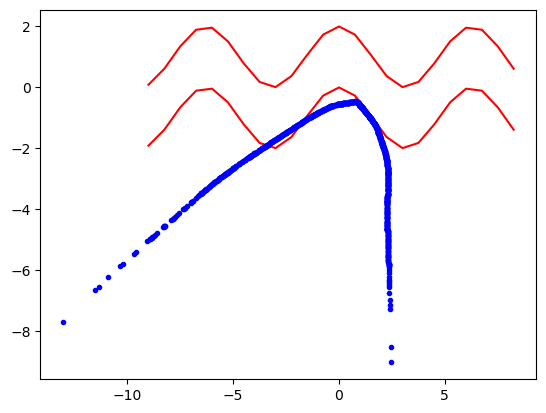

Epoch 2360: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2380: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2400: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


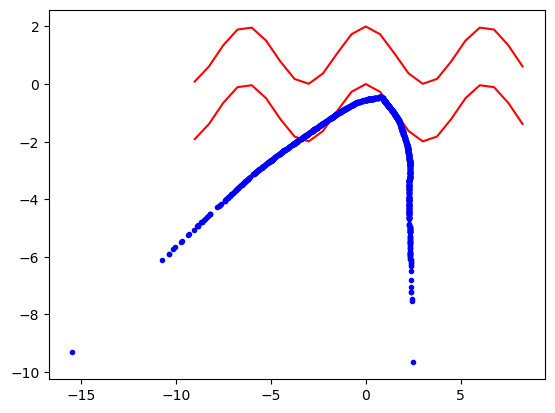

Epoch 2420: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2440: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2460: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


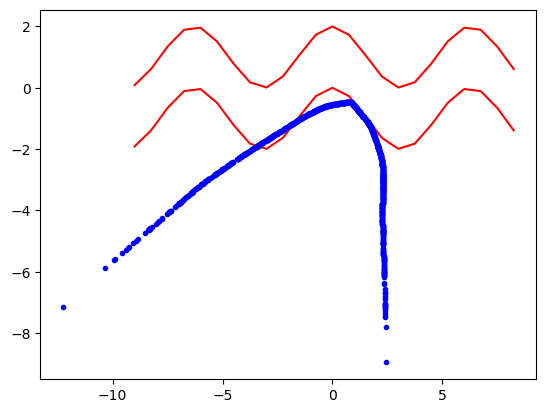

Epoch 2480: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2500: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2520: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


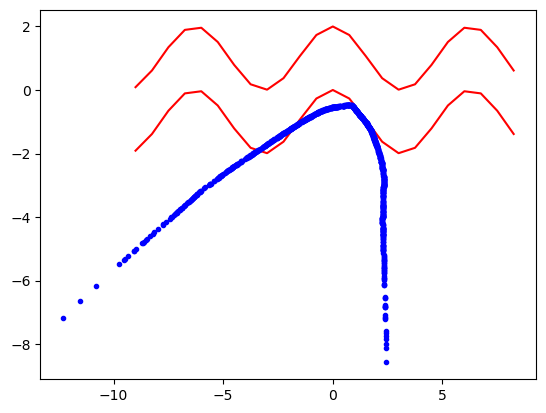

Epoch 2540: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2560: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2580: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


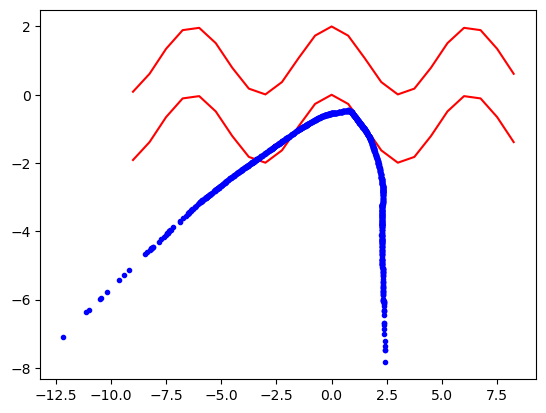

Epoch 2600: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2620: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2640: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


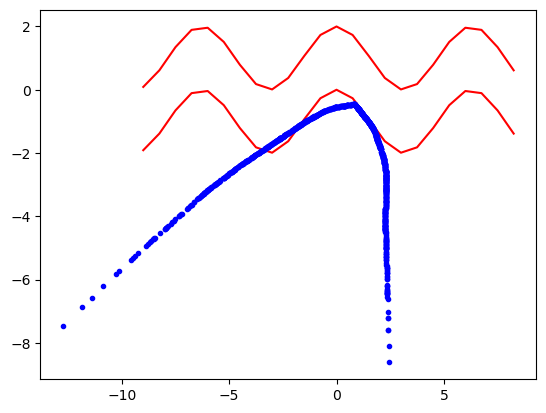

Epoch 2660: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2680: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2700: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


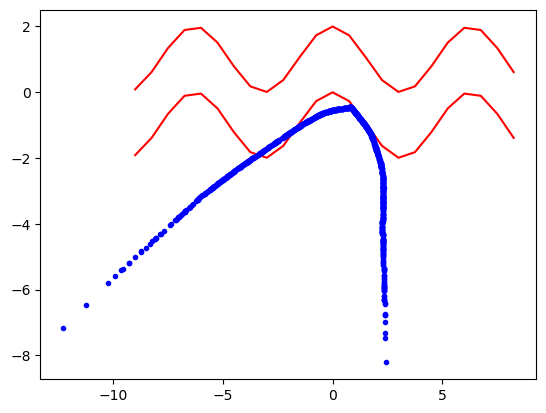

Epoch 2720: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2740: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2760: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


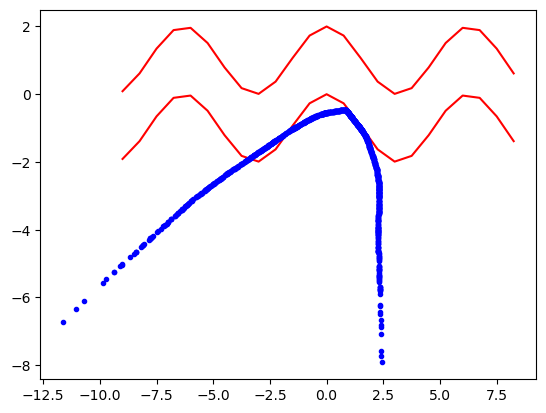

Epoch 2780: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2800: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2820: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


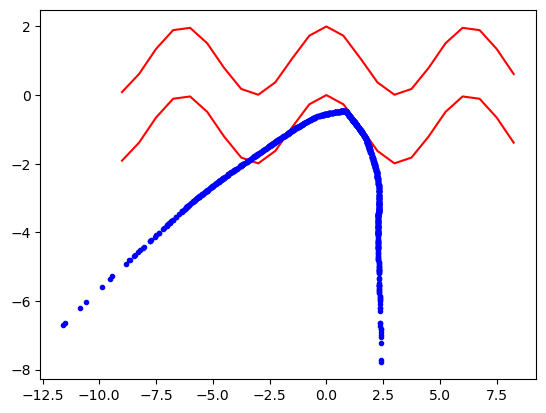

Epoch 2840: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2860: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2880: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


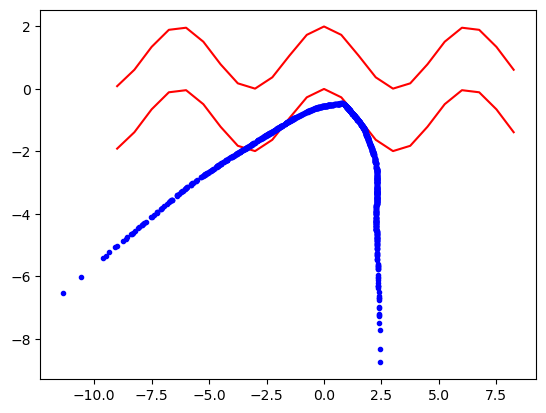

Epoch 2900: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2920: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2940: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


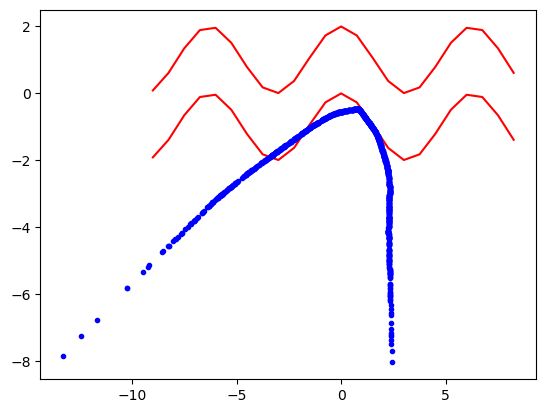

Epoch 2960: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 
Epoch 2980: D (0.6931 real_err, 0.6931 fake_err) G (0.6931 err) 


In [10]:
train(batch_size, model, device, G, D, criterion, d_optimizer, g_optimizer, latent_dim, epochs)